In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install dtreeviz
!pip install fastbook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credential/kaggle.json


In [11]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Download Dataset

In [14]:
cred_path = Path('/kaggle/input/credential/kaggle.json').expanduser()

In [15]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
username = user_secrets.get_secret("kaggle_username")
key = user_secrets.get_secret("kaggle_key")
os.environ["KAGGLE_USERNAME"] = username
os.environ["KAGGLE_KEY"] = key
api = KaggleApi()
api.authenticate()

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')
     

100%|██████████| 48.4M/48.4M [00:00<00:00, 145MB/s] 


(#7) [Path('bluebook-for-bulldozers/Test.csv'),Path('bluebook-for-bulldozers/Machine_Appendix.csv'),Path('bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('bluebook-for-bulldozers/median_benchmark.csv'),Path('bluebook-for-bulldozers/TrainAndValid.csv'),Path('bluebook-for-bulldozers/ValidSolution.csv'),Path('bluebook-for-bulldozers/Valid.csv')]

In [16]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [17]:
df

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,...,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,...,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,...,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,...,NaN,NaN,NaN,NaN


In [18]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [19]:
df.columns.size

53

In [20]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [21]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

/tmp/ipykernel_34/2252637013.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [22]:
dep_var = 'SalePrice'
# metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices
# normalise the price
df[dep_var] = np.log(df[dep_var])

# Handling Dates

In [23]:
# replace every date column with a set of date metadata columns, such as holiday, day of week, and month
df = add_datepart(df, 'saledate')

# performing same on test
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [24]:
# new columns
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

# Data preprocessing

In [25]:
# using fast ai TabularPandas for data preprocessing
# replace columns with a numeric categorical column
# replace missing values with the median of the column, and create a new Boolean column 
# that is set to True for any row where the value was missing.
procs = [Categorify, FillMissing]

# Creating Validation Set

In [26]:
df.saleYear, df.saleMonth

(0         2006
 1         2004
 2         2004
 3         2011
 4         2009
           ... 
 412693    2012
 412694    2012
 412695    2012
 412696    2012
 412697    2012
 Name: saleYear, Length: 412698, dtype: int64,
 0         11
 1          3
 2          2
 3          5
 4          7
           ..
 412693     3
 412694     1
 412695     1
 412696     3
 412697     1
 Name: saleMonth, Length: 412698, dtype: int64)

In [27]:
df_test.saleYear, df_test.saleMonth

(0        2012
 1        2012
 2        2012
 3        2012
 4        2012
          ... 
 12452    2012
 12453    2012
 12454    2012
 12455    2012
 12456    2012
 Name: saleYear, Length: 12457, dtype: int64,
 0         5
 1         5
 2         5
 3         5
 4         5
          ..
 12452    10
 12453    10
 12454    10
 12455    10
 12456     9
 Name: saleMonth, Length: 12457, dtype: int64)

In [28]:
# date range represented in the test set, covers a six-month period from May 2012
# which is later in time than any date in the training set

#  validation set will consist of data from after November 2011

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [29]:
# TabularPandas needs to be told which columns are continuous and which are categorical
# all string col is part of cat and integer whose cardinality is 1 or 0
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [30]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)


In [31]:
len(to.train),len(to.valid)

(404710, 7988)

In [32]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [33]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


# Saving the preprosses data

In [34]:
save_pickle(path/'to.pkl',to)
# to load
# to = (path/'to.pkl').load()

In [35]:
to = load_pickle(path/'to.pkl')

In [36]:
len(to)

412698

In [37]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [68]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [69]:
from fastbook import *

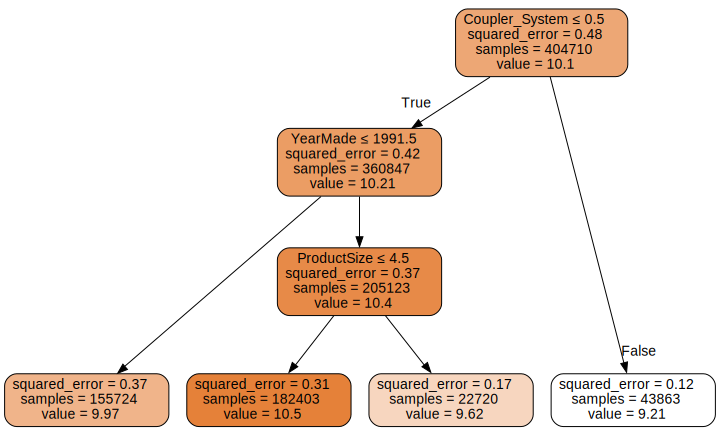

In [70]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [71]:
samp_idx = np.random.permutation(len(y))[:500]


In [72]:
 xs.iloc[samp_idx]

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
324272,1,402,137,21,0,0,0,43,9,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,2,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,1,2317285,529831,3433,136,2.0,2004,1709.0,2007,12,49,8,5,342,1.197072e+09
264768,0,1413,408,0,0,0,0,38,30,3,3,0,6,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1800962,1285226,9550,132,2.0,1990,0.0,2000,3,13,30,3,90,9.543744e+08
126147,0,2480,763,0,0,0,5,25,9,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,1,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,1473186,1402432,7511,132,9.0,1991,0.0,2006,2,8,22,2,53,1.140566e+09
126720,0,1701,511,59,0,0,0,73,35,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,2,1474005,1103001,3764,132,2.0,1996,0.0,1996,7,30,27,5,209,8.384256e+08
147667,0,2214,698,31,99,0,0,54,33,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,6,0,0,1,1,1,1,1,1,1,2,1519916,887519,2758,132,6.0,1994,0.0,1999,4,15,15,3,105,9.241344e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116225,0,1767,535,31,0,0,3,62,12,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,2,1453494,1542481,3854,132,1.0,1979,0.0,1999,10,43,26,1,299,9.408960e+08
128768,0,2169,692,43,0,0,0,51,43,5,5,0,1,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,6,0,0,1,1,1,1,1,1,1,2,1477560,1215553,4103,132,13.0,1973,0.0,1996,11,47,23,5,328,8.487072e+08
339779,0,1188,354,59,0,0,0,54,49,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,6,0,0,1,1,1,1,1,1,1,1,2355281,1743466,4763,136,1.0,1990,0.0,2008,9,38,16,1,260,1.221523e+09
267,3,785,252,43,0,0,0,3,28,1,1,2,3,1,3,1,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1140127,315896,3552,121,3.0,2003,1862.0,2006,8,32,10,3,222,1.155168e+09


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


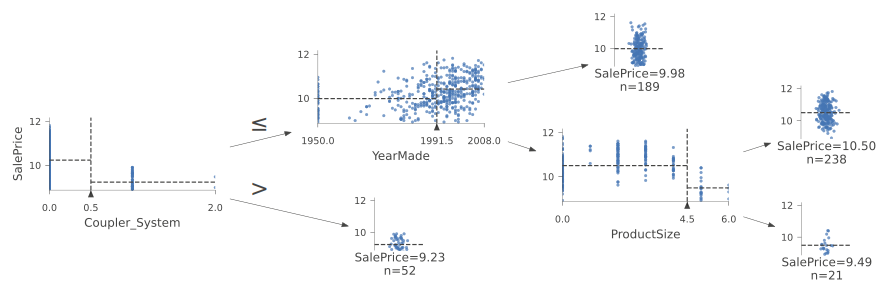

In [80]:
import dtreeviz
samp_idx = np.random.permutation(len(y))[:500]
viz_model=dtreeviz.model(m,
                   X_train=xs.iloc[samp_idx],
                   y_train=y.iloc[samp_idx],
                   feature_names=xs.columns,
                   target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')


In [51]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


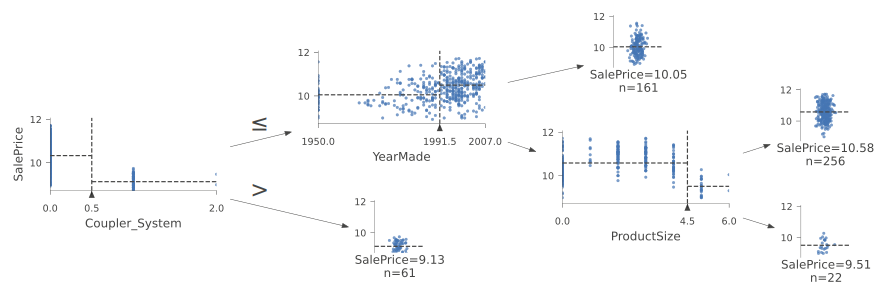

In [82]:

samp_idx = np.random.permutation(len(y))[:500]
viz_model=dtreeviz.model(m,
                   X_train=xs.iloc[samp_idx],
                   y_train=y.iloc[samp_idx],
                   feature_names=xs.columns,
                   target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

In [83]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [84]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

## The above tree is overfitting

In [91]:
# error on test set
m_rmse(m, xs, y)

0.0

In [92]:
# error on validation set
m_rmse(m, valid_xs, valid_y)

0.332642

In [89]:
m.get_n_leaves(), len(xs)


(324559, 404710)

### Reduce the number of tree leaf

In [93]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323406)

In [94]:
m.get_n_leaves()

12397

### Using bagging to improve accuracy 

In [95]:
# n_estimators defines the number of trees
# max_samples defines how many rows to sample for training each tree
# max_features defines how many columns to sample at each split point

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [96]:
m = rf(xs, y);

In [97]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170825, 0.232796)

In [104]:
xs

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,1,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09
1,2,1745,529,57,98,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,1,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09
2,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09
3,1,3716,1381,0,45,0,4,8,44,4,4,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139251,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1.305763e+09
4,3,4261,1538,0,0,0,0,40,32,3,3,0,1,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139253,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,0,490,160,108,0,0,5,13,44,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333344,1919201,21435,149,2.0,2005,0.0,2012,3,10,7,2,67,1.331078e+09
412694,0,491,160,108,63,0,5,17,9,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333345,1882122,21436,149,2.0,2005,0.0,2012,1,4,28,5,28,1.327709e+09
412695,0,490,160,108,0,0,5,13,9,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,1,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333347,1944213,21435,149,2.0,2005,0.0,2012,1,4,28,5,28,1.327709e+09
412696,0,490,160,108,0,0,5,13,44,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,1,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333348,1794518,21435,149,2.0,2006,0.0,2012,3,10,7,2,67,1.331078e+09


In [105]:
valid_xs_values = valid_xs.values
preds = np.stack([t.predict(valid_xs_values) for t in m.estimators_])

In [112]:
valid_xs_values.shape, preds.shape, preds.mean(0).shape

((7988, 66), (40, 7988), (7988,))

In [106]:
r_mse(preds.mean(0), r_mse(m.oob_prediction_, y))


0.232796

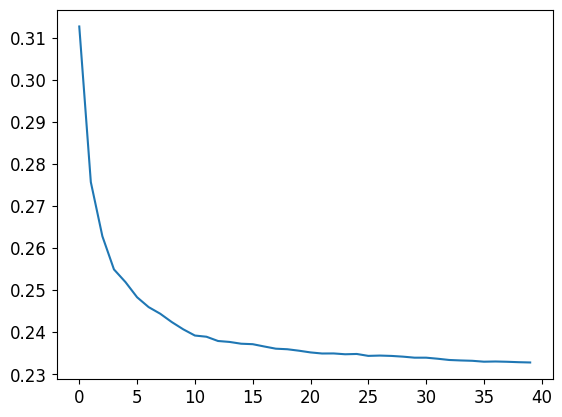

In [107]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error


In [113]:
r_mse(m.oob_prediction_, y)

0.210585